# Data Preparation

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
datasetPath = "/content/drive/MyDrive/Thesis/Code/GenerativeDataAugmentation/Coba18 - Testing All Dataset/augJoin - AllDataset - filtered.csv"
dataset = pd.read_csv(datasetPath, index_col=0, encoding="utf-8")
dataset

,text,emotion
0,im not talking about a studio. im talking abou...,anger
1,. . . Wait a fucking second,anger
2,"Oh [NAME], someone did it already, and it was ...",surprise
3,see im on here having fun meming on all yall b...,joy
4,Yeah - thanks - I vaguely remember this. I won...,surprise
...,...,...
78005,Soon: Mass death of pink-skinned Aussies.,disgust
78006,Ohhh sorry. I got it now. Thanks bruv,joy
78007,"Don't listen to the idiot, we love your posts!",anger
78008,i can feel more emotional now,sadness


In [3]:
dataset.rename(columns={'text' : 'Text', 'emotion' : 'Emotion'}, inplace=True)

In [4]:
dataset

,Text,Emotion
0,im not talking about a studio. im talking abou...,anger
1,. . . Wait a fucking second,anger
2,"Oh [NAME], someone did it already, and it was ...",surprise
3,see im on here having fun meming on all yall b...,joy
4,Yeah - thanks - I vaguely remember this. I won...,surprise
...,...,...
78005,Soon: Mass death of pink-skinned Aussies.,disgust
78006,Ohhh sorry. I got it now. Thanks bruv,joy
78007,"Don't listen to the idiot, we love your posts!",anger
78008,i can feel more emotional now,sadness


In [5]:
dataset = dataset[dataset.Emotion != 'love']

In [6]:
dataset['Emotion'].value_counts().sort_index()

anger       12987
disgust     10744
fear        13037
joy         14744
sadness     14168
surprise    12330
Name: Emotion, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dataset['emotion_encode'] = le.fit_transform(dataset['Emotion'])
dataset.head()

,Text,Emotion,emotion_encode
0,im not talking about a studio. im talking abou...,anger,0
1,. . . Wait a fucking second,anger,0
2,"Oh [NAME], someone did it already, and it was ...",surprise,5
3,see im on here having fun meming on all yall b...,joy,3
4,Yeah - thanks - I vaguely remember this. I won...,surprise,5


In [8]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [9]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


In [10]:
emotion_col = dataset.pop("Emotion")
emotion_col

0           anger
1           anger
2        surprise
3             joy
4        surprise
           ...   
78005     disgust
78006         joy
78007       anger
78008     sadness
78009    surprise
Name: Emotion, Length: 78010, dtype: object

In [11]:
training_data, validation_data, test_data = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])

In [12]:
print(training_data.shape)
print(validation_data.shape)
print(test_data.shape)

(62408, 2)
(7801, 2)
(7801, 2)


# One-hot Vector

In [13]:
trainX = np.array(training_data.iloc[:, 0])
trainY = np.array(training_data.iloc[:, 1])

testX = np.array(test_data.iloc[:, 0])
testY = np.array(test_data.iloc[:, 1])

valX = np.array(validation_data.iloc[:, 0])
valY = np.array(validation_data.iloc[:, 1])

In [14]:
trainY = pd.get_dummies(trainY).values
testY = pd.get_dummies(testY).values
valY = pd.get_dummies(valY).values

In [15]:
print(trainY.shape)
print(testY.shape)
print(valY.shape)

(62408, 6)
(7801, 6)
(7801, 6)


In [16]:
vocab_size = 5000
embedding_dim = 64
max_length = 80
oov_tok = '<OOV>'
trunc_type = 'pre'
padding_type = 'pre'

# Tokenizing, Sequencing, Padding

In [17]:
#Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(trainX)

tokenizer.word_index[''] = 0
tokenizer.index_word[0] = ''

word_index = tokenizer.word_index

In [18]:
len(word_index)

25951

In [19]:
vocab_size = len(tokenizer.word_index)
vocab_size

25951

In [20]:
#Sequencing
train_seqs = tokenizer.texts_to_sequences(trainX)
val_seqs = tokenizer.texts_to_sequences(valX)
test_seqs = tokenizer.texts_to_sequences(testX)

In [21]:
#Padding
train_seqs = pad_sequences(train_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_seqs = pad_sequences(val_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_seqs = pad_sequences(test_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Model Training

In [22]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1660864   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,735,558
Trainable params: 1,735,558
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

In [24]:
%%time
history = model.fit(train_seqs, trainY, epochs=num_epochs, validation_data=(val_seqs, valY), verbose=1)

Epoch 1/10
1951/1951 [==============================] - 46s 18ms/step - loss: 0.9485 - accuracy: 0.6524 - val_loss: 0.7040 - val_accuracy: 0.7614
Epoch 2/10
1951/1951 [==============================] - 18s 9ms/step - loss: 0.6150 - accuracy: 0.7893 - val_loss: 0.6622 - val_accuracy: 0.7744
Epoch 3/10
1951/1951 [==============================] - 18s 9ms/step - loss: 0.5496 - accuracy: 0.8100 - val_loss: 0.6617 - val_accuracy: 0.7736
Epoch 4/10
1951/1951 [==============================] - 18s 9ms/step - loss: 0.5048 - accuracy: 0.8236 - val_loss: 0.6604 - val_accuracy: 0.7758
Epoch 5/10
1951/1951 [==============================] - 18s 9ms/step - loss: 0.4642 - accuracy: 0.8363 - val_loss: 0.6762 - val_accuracy: 0.7759
Epoch 6/10
1951/1951 [==============================] - 17s 9ms/step - loss: 0.4288 - accuracy: 0.8461 - val_loss: 0.6824 - val_accuracy: 0.7754
Epoch 7/10
1951/1951 [==============================] - 18s 9ms/step - loss: 0.3977 - accuracy: 0.8569 - val_loss: 0.7269 - val_a

# Evaluation

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

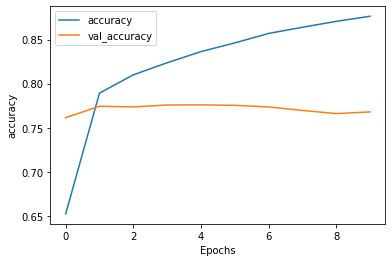

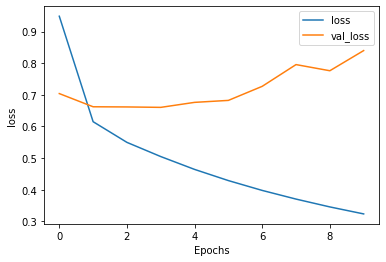

In [26]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [27]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(num_epochs):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history.history['accuracy'][i], history.history['loss'][i], history.history['val_accuracy'][i], history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.652384 	   0.948530 	   0.761441 	   0.703956
       2   0.789274 	   0.615042 	   0.774388 	   0.662229
       3   0.809960 	   0.549646 	   0.773619 	   0.661700
       4   0.823644 	   0.504779 	   0.775798 	   0.660352
       5   0.836303 	   0.464153 	   0.775926 	   0.676163
       6   0.846142 	   0.428796 	   0.775413 	   0.682401
       7   0.856877 	   0.397688 	   0.773619 	   0.726862
       8   0.863880 	   0.370280 	   0.769645 	   0.795625
       9   0.870578 	   0.345519 	   0.766056 	   0.776177
      10   0.876362 	   0.323389 	   0.767978 	   0.839930


In [28]:
y_pred = np.argmax(model.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model.evaluate(test_seqs, testY)

244/244 [==============================] - 1s 5ms/step - loss: 0.8418 - accuracy: 0.7709


In [29]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70      1400
           1       0.64      0.67      0.65       992
           2       0.85      0.84      0.84      1356
           3       0.83      0.86      0.84      1454
           4       0.78      0.79      0.78      1391
           5       0.77      0.76      0.76      1208

    accuracy                           0.77      7801
   macro avg       0.76      0.77      0.76      7801
weighted avg       0.77      0.77      0.77      7801

